In [287]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

Loading and Processing the Data for the 2021-2022 Premier Leauge Season

In [288]:
url_prev = 'https://raw.githubusercontent.com/Sunan2002/Premier-Leauge-Prediction-Model/main/Prem_21_22.csv'
data_prev = pd.read_csv(url_prev)
prev_features = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG','FTR', 'HTHG', 'HTAG', 
                 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 
                 'AY', 'HR', 'AR','Referee']
prev_stats = pd.concat([data_prev], sort='False')
prev_stats = prev_stats[prev_features]

<ipython-input-288-bbc40e1a68eb>:6: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  prev_stats = pd.concat([data_prev], sort='False')


Appending a column that will indicate the result of each fixture, we will later use result as the target value for our match and season predictions

In [289]:
def match_result(FTR):
  if FTR == 'H':
    return 0
  elif FTR == 'A':
    return 1
  else:
    return 2

In [290]:
prev_stats['Result'] = prev_stats.apply(lambda row: match_result(row.FTR), axis = 1)

In [291]:
print(prev_stats.shape)

(380, 22)


In [292]:
prev_stats

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HF,AF,HC,AC,HY,AY,HR,AR,Referee,Result
0,Brentford,Arsenal,2,0,H,1,0,H,8,22,...,12,8,2,5,0,0,0,0,M Oliver,0
1,Man United,Leeds,5,1,H,1,0,H,16,10,...,11,9,5,4,1,2,0,0,P Tierney,0
2,Burnley,Brighton,1,2,A,1,0,H,14,14,...,10,7,7,6,2,1,0,0,D Coote,1
3,Chelsea,Crystal Palace,3,0,H,2,0,H,13,4,...,15,11,5,2,0,0,0,0,J Moss,0
4,Everton,Southampton,3,1,H,0,1,A,14,6,...,13,15,6,8,2,0,0,0,A Madley,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Crystal Palace,Man United,1,0,H,1,0,H,6,10,...,12,22,3,6,2,4,0,0,M Atkinson,0
376,Leicester,Southampton,4,1,H,0,0,D,12,7,...,10,5,3,3,0,1,0,0,J Moss,0
377,Liverpool,Wolves,3,1,H,1,1,D,29,7,...,6,3,5,3,1,0,0,0,A Taylor,0
378,Man City,Aston Villa,3,2,H,0,1,A,24,4,...,5,11,13,1,0,1,0,0,M Oliver,0


# Home and Away Satistics Analysis per Team

In [293]:
home_2122 = prev_stats.groupby('HomeTeam').sum() #Summation of each team's home goals (full and half time), shots, corners, cards
away_2122 = prev_stats.groupby('AwayTeam').sum() #Summation of each team's away goals (full and half time), shots, corners, cards

<ipython-input-293-f2cc3cd359ba>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home_2122 = prev_stats.groupby('HomeTeam').sum() #Summation of each team's home goals (full and half time), shots, corners, cards
<ipython-input-293-f2cc3cd359ba>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  away_2122 = prev_stats.groupby('AwayTeam').sum() #Summation of each team's away goals (full and half time), shots, corners, cards


In [294]:
# Each team plays 19 home and away games each per season

home_2122['AHG'] = home_2122['FTHG'] / 19 #Average Home Goals
away_2122['AAG'] = away_2122['FTAG'] / 19 #Average Away Goals

home_2122['AHGC'] = home_2122['FTAG'] / 19 #Average Home Goals Conceded
away_2122['AAGC'] = away_2122['FTHG'] / 19 #Average Away Goals Conceded

home_2122['AHS'] = home_2122['HS'] / 19 #Average Home Shots
away_2122['AAS'] = away_2122['AS'] / 19 #Average Away Shots

home_2122['AHST'] = home_2122['HST'] / 19 #Average Home Shots on Target
away_2122['AAST'] = away_2122['AST'] / 19 #Average Away Shots on Target

home_2122['AHF'] = home_2122['HF'] / 19 #Average Home Fouls
away_2122['AAF'] = away_2122['AF'] / 19 #Average Away Fouls

home_2122['AHC'] = home_2122['HC'] / 19 #Average Home Corners
away_2122['AAC'] = away_2122['AC'] / 19 #Average Away Corners

home_2122['AHY'] = home_2122['HY'] / 19 #Average Home Yellow Cards
away_2122['AAY'] = away_2122['AY'] / 19 #Average Away Yellow Cards

home_2122['AHR'] = home_2122['HR'] / 19 #Average Home Red Cards
away_2122['AAR'] = away_2122['AR'] / 19 #Average Away Red Cards

In [295]:
home_2122

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AR,Result,AHG,AHGC,AHS,AHST,AHF,AHC,AHY,AHR
HomeTeam,,,,,,,,,,,,,,,,,,,,,
Arsenal,35,17,16,6,347,178,116,58,179,197,...,3,8,1.842105,0.894737,18.263158,6.105263,9.421053,6.684211,1.631579,0.052632
Aston Villa,29,29,12,14,235,225,86,80,190,253,...,1,18,1.526316,1.526316,12.368421,4.526316,10.000000,4.736842,1.631579,0.105263
Brentford,22,21,6,10,233,220,77,72,187,183,...,1,15,1.157895,1.105263,12.263158,4.052632,9.842105,4.631579,1.526316,0.105263
Brighton,19,23,9,13,280,228,67,81,208,179,...,0,21,1.000000,1.210526,14.736842,3.526316,10.947368,6.210526,1.684211,0.052632
Burnley,18,25,9,13,229,260,73,88,201,172,...,0,20,0.947368,1.315789,12.052632,3.842105,10.578947,5.368421,1.789474,0.000000
Chelsea,37,22,16,6,326,173,115,63,213,209,...,3,17,1.947368,1.157895,17.157895,6.052632,11.210526,7.263158,1.684211,0.000000
Crystal Palace,27,17,11,10,231,186,81,63,210,266,...,2,20,1.421053,0.894737,12.157895,4.263158,11.052632,4.789474,1.789474,0.000000
Everton,27,25,8,12,227,233,76,82,167,224,...,0,12,1.421053,1.315789,11.947368,4.000000,8.789474,4.894737,2.157895,0.263158
Leeds,19,38,8,16,264,274,75,108,236,190,...,0,21,1.000000,2.000000,13.894737,3.947368,12.421053,5.052632,2.789474,0.105263


In [296]:
away_2122

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,AR,Result,AAG,AAGC,AAS,AAST,AAF,AAC,AAY,AAR
AwayTeam,,,,,,,,,,,,,,,,,,,,,
Arsenal,31,26,15,17,247,241,89,81,179,184,...,3,11,1.368421,1.631579,12.684211,4.263158,9.684211,4.315789,1.526316,0.157895
Aston Villa,25,23,11,9,252,219,77,76,259,211,...,0,9,1.210526,1.315789,11.526316,4.000000,11.105263,5.578947,2.421053,0.000000
Brentford,35,26,19,10,282,209,111,77,194,184,...,1,14,1.368421,1.842105,11.000000,4.052632,9.684211,3.736842,1.684211,0.052632
Brighton,21,23,9,7,248,210,71,85,193,185,...,1,23,1.210526,1.105263,11.052632,4.473684,9.736842,4.421053,2.052632,0.052632
Burnley,28,16,14,8,343,178,99,52,167,193,...,2,18,0.842105,1.473684,9.368421,2.736842,10.157895,4.315789,1.789474,0.105263
Chelsea,11,39,4,18,168,266,56,96,196,196,...,1,20,2.052632,0.578947,14.000000,5.052632,10.315789,5.473684,1.631579,0.052632
Crystal Palace,29,23,15,10,257,181,83,66,234,205,...,1,18,1.210526,1.526316,9.526316,3.473684,10.789474,4.473684,1.736842,0.052632
Everton,41,16,18,8,289,211,108,62,177,201,...,1,10,0.842105,2.157895,11.105263,3.263158,10.578947,3.578947,1.842105,0.052632
Leeds,41,23,19,8,308,221,123,79,196,233,...,1,15,1.210526,2.157895,11.631579,4.157895,12.263158,3.947368,2.473684,0.052632


In [297]:
team_2122 = pd.DataFrame()
team_2122['Team'] = home_2122.index

team_2122 = team_2122.merge(home_2122['AHG'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAG'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHGC'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAGC'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHS'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAS'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHST'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAST'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHF'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAF'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHC'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAC'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHY'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAY'], left_on='Team', right_index=True)

team_2122 = team_2122.merge(home_2122['AHR'], left_on='Team', right_index=True)
team_2122 = team_2122.merge(away_2122['AAR'], left_on='Team', right_index=True)

In [298]:
team_2122.set_index('Team', inplace=True)
print(team_2122.shape)
team_2122

(20, 16)


,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,AHF,AAF,AHC,AAC,AHY,AAY,AHR,AAR
Team,,,,,,,,,,,,,,,,
Arsenal,1.842105,1.368421,0.894737,1.631579,18.263158,12.684211,6.105263,4.263158,9.421053,9.684211,6.684211,4.315789,1.631579,1.526316,0.052632,0.157895
Aston Villa,1.526316,1.210526,1.526316,1.315789,12.368421,11.526316,4.526316,4.000000,10.000000,11.105263,4.736842,5.578947,1.631579,2.421053,0.105263,0.000000
Brentford,1.157895,1.368421,1.105263,1.842105,12.263158,11.000000,4.052632,4.052632,9.842105,9.684211,4.631579,3.736842,1.526316,1.684211,0.105263,0.052632
Brighton,1.000000,1.210526,1.210526,1.105263,14.736842,11.052632,3.526316,4.473684,10.947368,9.736842,6.210526,4.421053,1.684211,2.052632,0.052632,0.052632
Burnley,0.947368,0.842105,1.315789,1.473684,12.052632,9.368421,3.842105,2.736842,10.578947,10.157895,5.368421,4.315789,1.789474,1.789474,0.000000,0.105263
Chelsea,1.947368,2.052632,1.157895,0.578947,17.157895,14.000000,6.052632,5.052632,11.210526,10.315789,7.263158,5.473684,1.684211,1.631579,0.000000,0.052632
Crystal Palace,1.421053,1.210526,0.894737,1.526316,12.157895,9.526316,4.263158,3.473684,11.052632,10.789474,4.789474,4.473684,1.789474,1.736842,0.000000,0.052632
Everton,1.421053,0.842105,1.315789,2.157895,11.947368,11.105263,4.000000,3.263158,8.789474,10.578947,4.894737,3.578947,2.157895,1.842105,0.263158,0.052632
Leeds,1.000000,1.210526,2.000000,2.157895,13.894737,11.631579,3.947368,4.157895,12.421053,12.263158,5.052632,3.947368,2.789474,2.473684,0.105263,0.052632


# Matchup Analysis

In [299]:
matchup_col = ['HomeTeam', 'AwayTeam']
matchups_2122 = prev_stats[matchup_col]
matchups_2122 = matchups_2122.merge(team_2122['AHG'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAG'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHGC'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAGC'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHS'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAS'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHST'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAST'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHF'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAF'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHC'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAC'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHY'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAY'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AHR'], left_on='HomeTeam', right_index=True, how='left')
matchups_2122 = matchups_2122.merge(team_2122['AAR'], left_on='AwayTeam', right_index=True, how='left')
matchups_2122

,HomeTeam,AwayTeam,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,AHF,AAF,AHC,AAC,AHY,AAY,AHR,AAR
0,Brentford,Arsenal,1.157895,1.368421,1.105263,1.631579,12.263158,12.684211,4.052632,4.263158,9.842105,9.684211,4.631579,4.315789,1.526316,1.526316,0.105263,0.157895
1,Man United,Leeds,1.684211,1.210526,1.157895,2.157895,14.684211,11.631579,5.263158,4.157895,8.894737,12.263158,5.000000,3.947368,1.631579,2.473684,0.052632,0.052632
2,Burnley,Brighton,0.947368,1.210526,1.315789,1.105263,12.052632,11.052632,3.842105,4.473684,10.578947,9.736842,5.368421,4.421053,1.789474,2.052632,0.000000,0.052632
3,Chelsea,Crystal Palace,1.947368,1.210526,1.157895,1.526316,17.157895,9.526316,6.052632,3.473684,11.210526,10.789474,7.263158,4.473684,1.684211,1.736842,0.000000,0.052632
4,Everton,Southampton,1.421053,1.052632,1.315789,2.263158,11.947368,12.947368,4.000000,4.368421,8.789474,10.315789,4.894737,6.263158,2.157895,1.684211,0.263158,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Crystal Palace,Man United,1.421053,1.315789,0.894737,1.842105,12.157895,12.052632,4.263158,4.578947,11.052632,11.894737,4.789474,5.473684,1.789474,2.315789,0.000000,0.052632
376,Leicester,Southampton,1.789474,1.052632,1.210526,2.263158,12.473684,12.947368,4.947368,4.368421,8.842105,10.315789,4.894737,6.263158,1.157895,1.684211,0.000000,0.052632
377,Liverpool,Wolves,2.578947,0.947368,0.473684,0.947368,21.263158,9.421053,7.157895,3.421053,9.052632,9.894737,8.000000,4.210526,1.210526,1.473684,0.000000,0.052632
378,Man City,Aston Villa,3.052632,1.210526,0.789474,1.315789,19.000000,11.526316,7.000000,4.000000,8.368421,11.105263,8.947368,5.578947,0.842105,2.421053,0.052632,0.000000


We will now be generating an Attack and Defense Potency Rating for each team 
based on calculations from a Poisson model we read about from Football XG
Source: https://footballxg.com/2020/12/22/create-your-own-power-ratings/

In [300]:
avg_home_goals_2122 = prev_stats['FTHG'].sum() / prev_stats.shape[0]
avg_away_goals_2122 = prev_stats['FTAG'].sum() / prev_stats.shape[0]
print(avg_home_goals_2122)
print(avg_away_goals_2122)

1.513157894736842
1.305263157894737


In [301]:
def home_attack_potency(AHG):
  return (AHG / avg_home_goals_2122)
def away_attack_potency(AAG):
  return (AAG / avg_away_goals_2122)
def home_defensive_potency(AHGC):
  return (avg_away_goals_2122 / AHGC)
def away_defensive_potency(AAGC):
  return (avg_home_goals_2122 / AAGC) 

In [305]:
team_2122['HAP'] = team_2122.apply(lambda row: home_attack_potency(row.AHG), axis = 1) #Home Attack Potency
team_2122['AAP'] = team_2122.apply(lambda row: away_attack_potency(row.AAG), axis = 1) #Away Attack Potency
team_2122['HDP'] = team_2122.apply(lambda row: home_defensive_potency(row.AHGC), axis = 1) #Home Defensive Potency
team_2122['ADP'] = team_2122.apply(lambda row: away_defensive_potency(row.AAGC), axis = 1) #Away Defensive Potency
print(team_2122[['HAP', 'AAP', 'HDP', 'ADP']])

                     HAP       AAP       HDP       ADP
Team                                                  
Arsenal         1.217391  1.048387  1.458824  0.927419
Aston Villa     1.008696  0.927419  0.855172  1.150000
Brentford       0.765217  1.048387  1.180952  0.821429
Brighton        0.660870  0.927419  1.078261  1.369048
Burnley         0.626087  0.645161  0.992000  1.026786
Chelsea         1.286957  1.572581  1.127273  2.613636
Crystal Palace  0.939130  0.927419  1.458824  0.991379
Everton         0.939130  0.645161  0.992000  0.701220
Leeds           0.660870  0.927419  0.652632  0.701220
Leicester       1.182609  1.129032  1.078261  0.798611
Liverpool       1.704348  1.814516  2.755556  1.691176
Man City        2.017391  1.653226  1.653333  2.613636
Man United      1.113043  1.008065  1.127273  0.821429
Newcastle       0.904348  0.725806  0.918519  0.821429
Norwich         0.417391  0.443548  0.576744  0.701220
Southampton     0.800000  0.806452  1.033333  0.668605
Tottenham 

In [309]:
matchups_2122['HAP'] = matchups_2122['AHG'] / avg_home_goals_2122
matchups_2122['AAP'] = matchups_2122['AAG'] / avg_away_goals_2122
matchups_2122['HDP'] = avg_away_goals_2122 / matchups_2122['AHGC']
matchups_2122['ADP'] = avg_home_goals_2122 / matchups_2122['AAGC']
matchups_2122['Result'] = prev_stats['Result']
matchups_2122

,HomeTeam,AwayTeam,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,...,AAC,AHY,AAY,AHR,AAR,HAP,AAP,HDP,ADP,Result
0,Brentford,Arsenal,1.157895,1.368421,1.105263,1.631579,12.263158,12.684211,4.052632,4.263158,...,4.315789,1.526316,1.526316,0.105263,0.157895,0.765217,1.048387,1.180952,0.927419,0
1,Man United,Leeds,1.684211,1.210526,1.157895,2.157895,14.684211,11.631579,5.263158,4.157895,...,3.947368,1.631579,2.473684,0.052632,0.052632,1.113043,0.927419,1.127273,0.701220,0
2,Burnley,Brighton,0.947368,1.210526,1.315789,1.105263,12.052632,11.052632,3.842105,4.473684,...,4.421053,1.789474,2.052632,0.000000,0.052632,0.626087,0.927419,0.992000,1.369048,1
3,Chelsea,Crystal Palace,1.947368,1.210526,1.157895,1.526316,17.157895,9.526316,6.052632,3.473684,...,4.473684,1.684211,1.736842,0.000000,0.052632,1.286957,0.927419,1.127273,0.991379,0
4,Everton,Southampton,1.421053,1.052632,1.315789,2.263158,11.947368,12.947368,4.000000,4.368421,...,6.263158,2.157895,1.684211,0.263158,0.052632,0.939130,0.806452,0.992000,0.668605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Crystal Palace,Man United,1.421053,1.315789,0.894737,1.842105,12.157895,12.052632,4.263158,4.578947,...,5.473684,1.789474,2.315789,0.000000,0.052632,0.939130,1.008065,1.458824,0.821429,0
376,Leicester,Southampton,1.789474,1.052632,1.210526,2.263158,12.473684,12.947368,4.947368,4.368421,...,6.263158,1.157895,1.684211,0.000000,0.052632,1.182609,0.806452,1.078261,0.668605,0
377,Liverpool,Wolves,2.578947,0.947368,0.473684,0.947368,21.263158,9.421053,7.157895,3.421053,...,4.210526,1.210526,1.473684,0.000000,0.052632,1.704348,0.725806,2.755556,1.597222,0
378,Man City,Aston Villa,3.052632,1.210526,0.789474,1.315789,19.000000,11.526316,7.000000,4.000000,...,5.578947,0.842105,2.421053,0.052632,0.000000,2.017391,0.927419,1.653333,1.150000,0


# Training with the XGBClassification Model using the 2021-2022 Dataset

Preparing the model and training data

In [311]:
X_2122 = matchups_2122
y_2122 = matchups_2122['Result']
X_2122 = X_2122.drop(['HomeTeam','AwayTeam','Result'], axis=1)

In [312]:
X_2122

,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,AHF,AAF,AHC,AAC,AHY,AAY,AHR,AAR,HAP,AAP,HDP,ADP
0,1.157895,1.368421,1.105263,1.631579,12.263158,12.684211,4.052632,4.263158,9.842105,9.684211,4.631579,4.315789,1.526316,1.526316,0.105263,0.157895,0.765217,1.048387,1.180952,0.927419
1,1.684211,1.210526,1.157895,2.157895,14.684211,11.631579,5.263158,4.157895,8.894737,12.263158,5.000000,3.947368,1.631579,2.473684,0.052632,0.052632,1.113043,0.927419,1.127273,0.701220
2,0.947368,1.210526,1.315789,1.105263,12.052632,11.052632,3.842105,4.473684,10.578947,9.736842,5.368421,4.421053,1.789474,2.052632,0.000000,0.052632,0.626087,0.927419,0.992000,1.369048
3,1.947368,1.210526,1.157895,1.526316,17.157895,9.526316,6.052632,3.473684,11.210526,10.789474,7.263158,4.473684,1.684211,1.736842,0.000000,0.052632,1.286957,0.927419,1.127273,0.991379
4,1.421053,1.052632,1.315789,2.263158,11.947368,12.947368,4.000000,4.368421,8.789474,10.315789,4.894737,6.263158,2.157895,1.684211,0.263158,0.052632,0.939130,0.806452,0.992000,0.668605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1.421053,1.315789,0.894737,1.842105,12.157895,12.052632,4.263158,4.578947,11.052632,11.894737,4.789474,5.473684,1.789474,2.315789,0.000000,0.052632,0.939130,1.008065,1.458824,0.821429
376,1.789474,1.052632,1.210526,2.263158,12.473684,12.947368,4.947368,4.368421,8.842105,10.315789,4.894737,6.263158,1.157895,1.684211,0.000000,0.052632,1.182609,0.806452,1.078261,0.668605
377,2.578947,0.947368,0.473684,0.947368,21.263158,9.421053,7.157895,3.421053,9.052632,9.894737,8.000000,4.210526,1.210526,1.473684,0.000000,0.052632,1.704348,0.725806,2.755556,1.597222
378,3.052632,1.210526,0.789474,1.315789,19.000000,11.526316,7.000000,4.000000,8.368421,11.105263,8.947368,5.578947,0.842105,2.421053,0.052632,0.000000,2.017391,0.927419,1.653333,1.150000


In [313]:
y_2122

0      0
1      0
2      1
3      0
4      0
      ..
375    0
376    0
377    0
378    0
379    1
Name: Result, Length: 380, dtype: int64

In [314]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_2122, y_2122, test_size=0.2, random_state=2)
xgb = XGBClassifier()
optimization_dict = {'max_depth': [2,4,6,8,10,12], 'n_estimators': [50,100,200,400]}
model = GridSearchCV(xgb, optimization_dict, scoring='accuracy', verbose=1)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [315]:
prediction_2122 = xgb.predict(X_test)
train_score = accuracy_score(y_test,prediction_2122)
cross_val_scores = cross_val_score(xgb, X_train, y_train, cv=8)

In [316]:
print("21-22 Season Accuracy Score: ", train_score)
print("\n21-22 Season Cross-Validation Scores")
print(cross_val_scores)

21-22 Season Accuracy Score:  0.4868421052631579

21-22 Season Cross-Validation Scores
[0.5        0.36842105 0.47368421 0.5        0.52631579 0.47368421
 0.60526316 0.34210526]


Text(113.9222222222222, 0.5, 'predicted label')

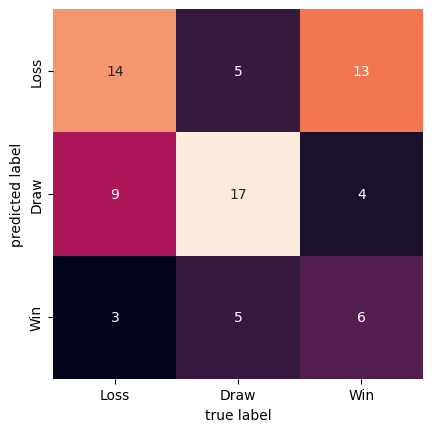

In [317]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, prediction_2122)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
cbar=False, xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [319]:
predicted_2122 = pd.DataFrame(xgb.predict(X_2122), columns=['Predicted'])
matchups_2122['Predicted'] = predicted_2122
matchups_2122

,HomeTeam,AwayTeam,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,...,AHY,AAY,AHR,AAR,HAP,AAP,HDP,ADP,Result,Predicted
0,Brentford,Arsenal,1.157895,1.368421,1.105263,1.631579,12.263158,12.684211,4.052632,4.263158,...,1.526316,1.526316,0.105263,0.157895,0.765217,1.048387,1.180952,0.927419,0,0
1,Man United,Leeds,1.684211,1.210526,1.157895,2.157895,14.684211,11.631579,5.263158,4.157895,...,1.631579,2.473684,0.052632,0.052632,1.113043,0.927419,1.127273,0.701220,0,0
2,Burnley,Brighton,0.947368,1.210526,1.315789,1.105263,12.052632,11.052632,3.842105,4.473684,...,1.789474,2.052632,0.000000,0.052632,0.626087,0.927419,0.992000,1.369048,1,2
3,Chelsea,Crystal Palace,1.947368,1.210526,1.157895,1.526316,17.157895,9.526316,6.052632,3.473684,...,1.684211,1.736842,0.000000,0.052632,1.286957,0.927419,1.127273,0.991379,0,0
4,Everton,Southampton,1.421053,1.052632,1.315789,2.263158,11.947368,12.947368,4.000000,4.368421,...,2.157895,1.684211,0.263158,0.052632,0.939130,0.806452,0.992000,0.668605,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Crystal Palace,Man United,1.421053,1.315789,0.894737,1.842105,12.157895,12.052632,4.263158,4.578947,...,1.789474,2.315789,0.000000,0.052632,0.939130,1.008065,1.458824,0.821429,0,0
376,Leicester,Southampton,1.789474,1.052632,1.210526,2.263158,12.473684,12.947368,4.947368,4.368421,...,1.157895,1.684211,0.000000,0.052632,1.182609,0.806452,1.078261,0.668605,0,0
377,Liverpool,Wolves,2.578947,0.947368,0.473684,0.947368,21.263158,9.421053,7.157895,3.421053,...,1.210526,1.473684,0.000000,0.052632,1.704348,0.725806,2.755556,1.597222,0,0
378,Man City,Aston Villa,3.052632,1.210526,0.789474,1.315789,19.000000,11.526316,7.000000,4.000000,...,0.842105,2.421053,0.052632,0.000000,2.017391,0.927419,1.653333,1.150000,0,0


What our standings table would have looked like by the end of the season

In [344]:
table_2122 = pd.DataFrame(index=team_2122.index)
table_2122['Final Points'] = 0
table_2122['Predicted Points'] = 0
def calculate_points(home, away, result, col):
  if result == 2:
    # print("Draw")
    table_2122.loc[home,col] += 1
    table_2122.loc[away,col] += 1
  elif result == 0:
    # print(home + " Win")
    table_2122.loc[home,col] += 3
  elif result == 1:
    # print(away + " Win")
    table_2122.loc[away,col] += 3
  # print(home + ": " + str(table_2122.loc[home,col]))
  # print(away + ": " + str(table_2122.loc[away,col]))
  # print("\n\n")

for index, row in matchups_2122.iterrows():
  calculate_points(row.HomeTeam,row.AwayTeam,row.Result,'Final Points')
  calculate_points(row.HomeTeam,row.AwayTeam,row.Predicted,'Predicted Points')

table_2122.sort_values(by='Final Points', ascending=0)

,Final Points,Predicted Points
Team,,
Man City,93,93
Liverpool,92,97
Chelsea,74,78
Tottenham,71,60
Arsenal,69,77
Man United,58,62
West Ham,56,54
Leicester,52,48
Brighton,51,49


# Testing the data on the 22-23 Season

In [358]:
url_curr = 'https://raw.githubusercontent.com/Sunan2002/Premier-Leauge-Prediction-Model/main/Prem_22_23.csv'
data_curr = pd.read_csv(url_curr)
curr_features = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG','FTR', 'HTHG', 'HTAG', 
                 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 
                 'AY', 'HR', 'AR','Referee']
curr_stats = pd.concat([data_curr], sort='False')
curr_stats = curr_stats[curr_features]

<ipython-input-358-c589d880b086>:6: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  curr_stats = pd.concat([data_curr], sort='False')


In [359]:
curr_stats['Result'] = curr_stats.apply(lambda row: match_result(row.FTR), axis = 1)
print(curr_stats.shape)
curr_stats

(296, 22)


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HF,AF,HC,AC,HY,AY,HR,AR,Referee,Result
0,Crystal Palace,Arsenal,0,2,A,0,1,A,10,10,...,16,11,3,5,1,2,0,0,A Taylor,1
1,Fulham,Liverpool,2,2,D,1,0,H,9,11,...,7,9,4,4,2,0,0,0,A Madley,2
2,Bournemouth,Aston Villa,2,0,H,1,0,H,7,15,...,18,16,5,5,3,3,0,0,P Bankes,0
3,Leeds,Wolves,2,1,H,1,1,D,12,15,...,13,9,6,4,2,0,0,0,R Jones,0
4,Newcastle,Nott'm Forest,2,0,H,0,0,D,23,5,...,9,14,11,1,0,3,0,0,S Hooper,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Tottenham,Brighton,2,1,H,1,1,D,9,17,...,15,15,3,7,3,1,0,0,S Attwell,0
292,Wolves,Chelsea,1,0,H,1,0,H,9,13,...,14,10,8,8,2,5,0,0,P Bankes,0
293,Southampton,Man City,1,4,A,0,1,A,4,13,...,6,10,0,10,0,2,0,0,R Jones,1
294,Leeds,Crystal Palace,1,5,A,1,1,D,11,16,...,11,8,2,4,3,1,0,0,S Hooper,1


In [360]:
home_2223 = curr_stats.groupby('HomeTeam').sum() #Summation of each team's home goals (full and half time), shots, corners, cards
away_2223 = curr_stats.groupby('AwayTeam').sum() #Summation of each team's away goals (full and half time), shots, corners, cards

home_2223['AHG'] = home_2223['FTHG'] / 15 #Average Home Goals
away_2223['AAG'] = away_2223['FTAG'] / 15 #Average Away Goals

home_2223['AHGC'] = home_2223['FTAG'] / 15 #Average Home Goals Conceded
away_2223['AAGC'] = away_2223['FTHG'] / 15 #Average Away Goals Conceded

home_2223['AHS'] = home_2223['HS'] / 15 #Average Home Shots
away_2223['AAS'] = away_2223['AS'] / 15 #Average Away Shots

home_2223['AHST'] = home_2223['HST'] / 15 #Average Home Shots on Target
away_2223['AAST'] = away_2223['AST'] / 15 #Average Away Shots on Target

home_2223['AHF'] = home_2223['HF'] / 15 #Average Home Fouls
away_2223['AAF'] = away_2223['AF'] / 15 #Average Away Fouls

home_2223['AHC'] = home_2223['HC'] / 15 #Average Home Corners
away_2223['AAC'] = away_2223['AC'] / 15 #Average Away Corners

home_2223['AHY'] = home_2223['HY'] / 15 #Average Home Yellow Cards
away_2223['AAY'] = away_2223['AY'] / 15 #Average Away Yellow Cards

home_2223['AHR'] = home_2223['HR'] / 15 #Average Home Red Cards
away_2223['AAR'] = away_2223['AR'] / 15 #Average Away Red Cards

print(home_2223)
print(away_2223)

                FTHG  FTAG  HTHG  HTAG   HS   AS  HST  AST   HF   AF  ...  AR  \
HomeTeam                                                              ...       
Arsenal           42    18    14     6  285  108   97   51  142  173  ...   1   
Aston Villa       25    19    14     9  176  160   70   52  148  163  ...   1   
Bournemouth       15    19     7    12  149  226   52   71  169  154  ...   0   
Brentford         29    16    16     5  172  204   72   76  134  168  ...   1   
Brighton          25    14    10     8  238  112  100   42  149  158  ...   0   
Chelsea           16    12     4     2  201  152   60   55  158  182  ...   0   
Crystal Palace    14    19     4     7  172  193   50   70  183  197  ...   0   
Everton           13    17     5     6  184  200   68   68  145  177  ...   1   
Fulham            21    21     8    13  195  176   64   79  148  165  ...   2   
Leeds             21    24    10    11  201  193   68   62  191  180  ...   1   
Leicester         17    20  

<ipython-input-360-89929738ff62>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home_2223 = curr_stats.groupby('HomeTeam').sum() #Summation of each team's home goals (full and half time), shots, corners, cards
<ipython-input-360-89929738ff62>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  away_2223 = curr_stats.groupby('AwayTeam').sum() #Summation of each team's away goals (full and half time), shots, corners, cards


In [361]:
team_2223 = pd.DataFrame()
team_2223['Team'] = home_2223.index

team_2223 = team_2223.merge(home_2223['AHG'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAG'], left_on='Team', right_index=True)

team_2223 = team_2223.merge(home_2223['AHGC'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAGC'], left_on='Team', right_index=True)

team_2223 = team_2223.merge(home_2223['AHS'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAS'], left_on='Team', right_index=True)

team_2223 = team_2223.merge(home_2223['AHST'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAST'], left_on='Team', right_index=True)
                          
team_2223 = team_2223.merge(home_2223['AHF'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAF'], left_on='Team', right_index=True)

team_2223 = team_2223.merge(home_2223['AHC'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAC'], left_on='Team', right_index=True)

team_2223 = team_2223.merge(home_2223['AHY'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAY'], left_on='Team', right_index=True)

team_2223 = team_2223.merge(home_2223['AHR'], left_on='Team', right_index=True)
team_2223 = team_2223.merge(away_2223['AAR'], left_on='Team', right_index=True)

team_2223.set_index('Team', inplace=True)
team_2223

,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,AHF,AAF,AHC,AAC,AHY,AAY,AHR,AAR
Team,,,,,,,,,,,,,,,,
Arsenal,2.800000,2.000000,1.200000,0.733333,19.000000,13.266667,6.466667,4.333333,9.466667,9.666667,7.066667,5.000000,1.000000,1.866667,0.000000,0.000000
Aston Villa,1.666667,1.066667,1.266667,1.400000,11.733333,10.800000,4.666667,3.600000,9.866667,12.600000,4.266667,3.733333,1.733333,2.200000,0.000000,0.066667
Bournemouth,1.000000,0.866667,1.266667,2.533333,9.933333,8.200000,3.466667,3.400000,11.266667,9.600000,4.133333,3.466667,1.733333,1.866667,0.000000,0.000000
Brentford,1.933333,1.200000,1.066667,1.600000,11.466667,9.133333,4.800000,3.600000,8.933333,9.666667,4.600000,4.066667,1.266667,1.400000,0.066667,0.000000
Brighton,1.666667,1.800000,0.933333,1.466667,15.866667,12.666667,6.666667,4.533333,9.933333,10.000000,7.266667,4.600000,1.466667,1.000000,0.000000,0.000000
Chelsea,1.066667,0.866667,0.800000,1.266667,13.400000,11.933333,4.000000,4.066667,10.533333,11.000000,6.533333,5.133333,2.133333,2.066667,0.066667,0.133333
Crystal Palace,0.933333,1.000000,1.266667,1.400000,11.466667,10.066667,3.333333,3.733333,12.200000,11.666667,4.533333,4.333333,2.066667,2.333333,0.133333,0.066667
Everton,0.866667,0.666667,1.133333,1.733333,12.266667,9.000000,4.533333,2.733333,9.666667,10.733333,5.133333,3.733333,2.000000,2.266667,0.066667,0.000000
Fulham,1.400000,1.200000,1.400000,1.266667,13.000000,9.333333,4.266667,3.400000,9.866667,10.933333,5.800000,3.466667,1.466667,3.133333,0.066667,0.000000


In [375]:
url_fixtures = 'https://raw.githubusercontent.com/Sunan2002/Premier-Leauge-Prediction-Model/main/England-Premier-League-Season-2022-2023-Fixture.csv'
data_fixtures = pd.read_csv(url_fixtures)
fixture_features = ['Home','Away']
all_fixtures = pd.concat([data_fixtures], sort='False')
all_fixtures = all_fixtures[fixture_features]
all_fixtures

<ipython-input-375-cca555e698f3>:4: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  all_fixtures = pd.concat([data_fixtures], sort='False')


,Home,Away
0,Crystal Palace,Arsenal
1,Bournemouth,Aston Villa
2,Everton,Chelsea
3,Fulham,Liverpool
4,Leeds,Wolves
...,...,...
375,Everton,Bournemouth
376,Leeds,Tottenham
377,Leicester,West Ham
378,Manchester Utd,Fulham


In [378]:
matchups_2223 = curr_stats[matchup_col]
matchups_2223 = matchups_2223.merge(team_2223['AHG'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAG'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHGC'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAGC'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHS'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAS'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHST'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAST'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHF'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAF'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHC'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAC'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHY'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAY'], left_on='AwayTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AHR'], left_on='HomeTeam', right_index=True, how='left')
matchups_2223 = matchups_2223.merge(team_2223['AAR'], left_on='AwayTeam', right_index=True, how='left')

In [363]:
avg_home_goals_2223 = curr_stats['FTHG'].sum() / curr_stats.shape[0]
avg_away_goals_2223 = curr_stats['FTAG'].sum() / curr_stats.shape[0]
print(avg_home_goals_2223)
print(avg_away_goals_2223)

1.5810810810810811
1.1554054054054055


In [364]:
team_2223['HAP'] = team_2223.apply(lambda row: home_attack_potency(row.AHG), axis = 1) #Home Attack Potency
team_2223['AAP'] = team_2223.apply(lambda row: away_attack_potency(row.AAG), axis = 1) #Away Attack Potency
team_2223['HDP'] = team_2223.apply(lambda row: home_defensive_potency(row.AHGC), axis = 1) #Home Defensive Potency
team_2223['ADP'] = team_2223.apply(lambda row: away_defensive_potency(row.AAGC), axis = 1) #Away Defensive Potency
print(team_2223[['HAP', 'AAP', 'HDP', 'ADP']])

                     HAP       AAP       HDP       ADP
Team                                                  
Arsenal         1.850435  1.532258  1.087719  2.063397
Aston Villa     1.101449  0.817204  1.030471  1.080827
Bournemouth     0.660870  0.663978  1.030471  0.597299
Brentford       1.277681  0.919355  1.223684  0.945724
Brighton        1.101449  1.379032  1.398496  1.031699
Chelsea         0.704928  0.663978  1.631579  1.194598
Crystal Palace  0.616812  0.766129  1.030471  1.080827
Everton         0.572754  0.510753  1.151703  0.872976
Fulham          0.925217  0.919355  0.932331  1.194598
Leeds           0.925217  0.919355  0.815789  0.756579
Leicester       0.748986  1.174731  0.978947  0.709293
Liverpool       1.586087  0.715054  1.779904  0.945724
Man City        2.070725  1.430108  1.398496  1.745951
Man United      1.189565  0.868280  2.447368  0.782668
Newcastle       1.013333  1.276882  2.175439  1.891447
Nott'm Forest   0.837101  0.255376  1.087719  0.630482
Southampto

In [365]:
matchups_2223['HAP'] = matchups_2223['AHG'] / avg_home_goals_2223
matchups_2223['AAP'] = matchups_2223['AAG'] / avg_away_goals_2223
matchups_2223['HDP'] = avg_away_goals_2223 / matchups_2223['AHGC']
matchups_2223['ADP'] = avg_home_goals_2223 / matchups_2223['AAGC']
matchups_2223['Result'] = curr_stats['Result']
matchups_2223

,HomeTeam,AwayTeam,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,...,AAC,AHY,AAY,AHR,AAR,HAP,AAP,HDP,ADP,Result
0,Crystal Palace,Arsenal,0.933333,2.000000,1.266667,0.733333,11.466667,13.266667,3.333333,4.333333,...,5.000000,2.066667,1.866667,0.133333,0.000000,0.590313,1.730994,0.912162,2.156020,1
1,Fulham,Liverpool,1.400000,0.933333,1.400000,1.600000,13.000000,13.200000,4.266667,5.066667,...,5.666667,1.466667,1.666667,0.066667,0.000000,0.885470,0.807797,0.825290,0.988176,2
2,Bournemouth,Aston Villa,1.000000,1.066667,1.266667,1.400000,9.933333,10.800000,3.466667,3.600000,...,3.733333,1.733333,2.200000,0.000000,0.066667,0.632479,0.923197,0.912162,1.129344,0
3,Leeds,Wolves,1.400000,0.733333,1.600000,1.533333,13.400000,10.933333,4.533333,3.000000,...,4.133333,1.866667,2.133333,0.066667,0.133333,0.885470,0.634698,0.722128,1.031140,0
4,Newcastle,Nott'm Forest,1.533333,0.333333,0.600000,2.400000,15.933333,9.333333,5.266667,2.266667,...,4.400000,1.466667,1.933333,0.066667,0.000000,0.969801,0.288499,1.925676,0.658784,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Tottenham,Brighton,2.066667,1.800000,1.133333,1.466667,14.466667,12.666667,5.933333,4.533333,...,4.600000,2.333333,1.000000,0.066667,0.000000,1.307123,1.557895,1.019475,1.078010,0
292,Wolves,Chelsea,0.866667,0.866667,1.266667,1.266667,11.533333,11.933333,3.733333,4.066667,...,5.133333,2.066667,2.066667,0.200000,0.133333,0.548148,0.750097,0.912162,1.248222,0
293,Southampton,Man City,1.000000,1.866667,1.866667,0.866667,12.400000,15.666667,4.200000,5.400000,...,5.733333,1.400000,1.333333,0.000000,0.000000,0.632479,1.615595,0.618967,1.824324,1
294,Leeds,Crystal Palace,1.400000,1.000000,1.600000,1.400000,13.400000,10.066667,4.533333,3.733333,...,4.333333,1.866667,2.333333,0.066667,0.066667,0.885470,0.865497,0.722128,1.129344,1


In [366]:
X_2223 = matchups_2223
y_2223 = matchups_2223['Result']
X_2223 = X_2223.drop(['HomeTeam','AwayTeam','Result'], axis=1)

In [367]:
X_2223

,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,AHF,AAF,AHC,AAC,AHY,AAY,AHR,AAR,HAP,AAP,HDP,ADP
0,0.933333,2.000000,1.266667,0.733333,11.466667,13.266667,3.333333,4.333333,12.200000,9.666667,4.533333,5.000000,2.066667,1.866667,0.133333,0.000000,0.590313,1.730994,0.912162,2.156020
1,1.400000,0.933333,1.400000,1.600000,13.000000,13.200000,4.266667,5.066667,9.866667,10.400000,5.800000,5.666667,1.466667,1.666667,0.066667,0.000000,0.885470,0.807797,0.825290,0.988176
2,1.000000,1.066667,1.266667,1.400000,9.933333,10.800000,3.466667,3.600000,11.266667,12.600000,4.133333,3.733333,1.733333,2.200000,0.000000,0.066667,0.632479,0.923197,0.912162,1.129344
3,1.400000,0.733333,1.600000,1.533333,13.400000,10.933333,4.533333,3.000000,12.733333,12.666667,6.000000,4.133333,1.866667,2.133333,0.066667,0.133333,0.885470,0.634698,0.722128,1.031140
4,1.533333,0.333333,0.600000,2.400000,15.933333,9.333333,5.266667,2.266667,10.133333,10.933333,7.200000,4.400000,1.466667,1.933333,0.066667,0.000000,0.969801,0.288499,1.925676,0.658784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2.066667,1.800000,1.133333,1.466667,14.466667,12.666667,5.933333,4.533333,12.333333,10.000000,5.800000,4.600000,2.333333,1.000000,0.066667,0.000000,1.307123,1.557895,1.019475,1.078010
292,0.866667,0.866667,1.266667,1.266667,11.533333,11.933333,3.733333,4.066667,10.866667,11.000000,5.600000,5.133333,2.066667,2.066667,0.200000,0.133333,0.548148,0.750097,0.912162,1.248222
293,1.000000,1.866667,1.866667,0.866667,12.400000,15.666667,4.200000,5.400000,10.933333,9.466667,4.866667,5.733333,1.400000,1.333333,0.000000,0.000000,0.632479,1.615595,0.618967,1.824324
294,1.400000,1.000000,1.600000,1.400000,13.400000,10.066667,4.533333,3.733333,12.733333,11.666667,6.000000,4.333333,1.866667,2.333333,0.066667,0.066667,0.885470,0.865497,0.722128,1.129344


In [368]:
prediction_2223 = xgb.predict(X_2223)
test_score = accuracy_score(y_2223,prediction_2223)
print("22-23 Season Accuracy Score: ", train_score)

22-23 Season Accuracy Score:  0.4868421052631579


Text(113.9222222222222, 0.5, 'predicted label')

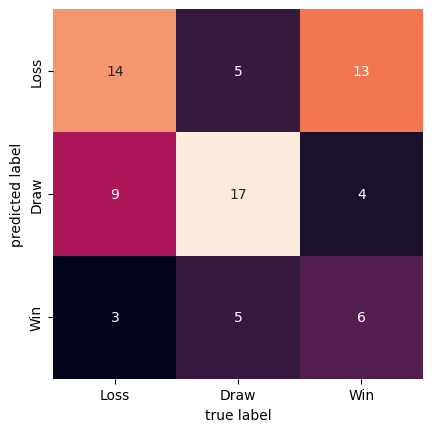

In [369]:
mat_2223 = confusion_matrix(y_2223, prediction_2223)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
cbar=False, xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [370]:
predicted_2223 = pd.DataFrame(prediction_2223, columns=['Predicted'])
matchups_2223 = matchups_2223.merge(predicted_2223,left_index=True,right_index=True)
matchups_2223

,HomeTeam,AwayTeam,AHG,AAG,AHGC,AAGC,AHS,AAS,AHST,AAST,...,AHY,AAY,AHR,AAR,HAP,AAP,HDP,ADP,Result,Predicted
0,Crystal Palace,Arsenal,0.933333,2.000000,1.266667,0.733333,11.466667,13.266667,3.333333,4.333333,...,2.066667,1.866667,0.133333,0.000000,0.590313,1.730994,0.912162,2.156020,1,1
1,Fulham,Liverpool,1.400000,0.933333,1.400000,1.600000,13.000000,13.200000,4.266667,5.066667,...,1.466667,1.666667,0.066667,0.000000,0.885470,0.807797,0.825290,0.988176,2,1
2,Bournemouth,Aston Villa,1.000000,1.066667,1.266667,1.400000,9.933333,10.800000,3.466667,3.600000,...,1.733333,2.200000,0.000000,0.066667,0.632479,0.923197,0.912162,1.129344,0,0
3,Leeds,Wolves,1.400000,0.733333,1.600000,1.533333,13.400000,10.933333,4.533333,3.000000,...,1.866667,2.133333,0.066667,0.133333,0.885470,0.634698,0.722128,1.031140,0,2
4,Newcastle,Nott'm Forest,1.533333,0.333333,0.600000,2.400000,15.933333,9.333333,5.266667,2.266667,...,1.466667,1.933333,0.066667,0.000000,0.969801,0.288499,1.925676,0.658784,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Tottenham,Brighton,2.066667,1.800000,1.133333,1.466667,14.466667,12.666667,5.933333,4.533333,...,2.333333,1.000000,0.066667,0.000000,1.307123,1.557895,1.019475,1.078010,0,1
292,Wolves,Chelsea,0.866667,0.866667,1.266667,1.266667,11.533333,11.933333,3.733333,4.066667,...,2.066667,2.066667,0.200000,0.133333,0.548148,0.750097,0.912162,1.248222,0,1
293,Southampton,Man City,1.000000,1.866667,1.866667,0.866667,12.400000,15.666667,4.200000,5.400000,...,1.400000,1.333333,0.000000,0.000000,0.632479,1.615595,0.618967,1.824324,1,1
294,Leeds,Crystal Palace,1.400000,1.000000,1.600000,1.400000,13.400000,10.066667,4.533333,3.733333,...,1.866667,2.333333,0.066667,0.066667,0.885470,0.865497,0.722128,1.129344,1,0


In [374]:
table_2223 = pd.DataFrame(index=team_2223.index)
table_2223['Current Points'] = 0
table_2223['Predicted Points'] = 0
def calculate_points(home, away, result, col):
  if result == 2:
    # print("Draw")
    table_2223.loc[home,col] += 1
    table_2223.loc[away,col] += 1
  elif result == 0:
    # print(home + " Win")
    table_2223.loc[home,col] += 3
  elif result == 1:
    # print(away + " Win")
    table_2223.loc[away,col] += 3
  # print(home + ": " + str(table_2122.loc[home,col]))
  # print(away + ": " + str(table_2122.loc[away,col]))
  # print("\n\n")

for index, row in matchups_2223.iterrows():
  calculate_points(row.HomeTeam,row.AwayTeam,row.Result,'Current Points')
  calculate_points(row.HomeTeam,row.AwayTeam,row.Predicted,'Predicted Points')

table_2223.sort_values(by='Current Points', ascending=0)

,Current Points,Predicted Points
Team,,
Arsenal,73,81
Man City,67,77
Newcastle,56,69
Man United,56,40
Tottenham,53,37
Aston Villa,47,43
Brighton,46,69
Liverpool,44,47
Brentford,43,44


# We will now try to predict the final season standings

In [ ]:
dict = {}